# Anomaly detection via *Rolling z-score*

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from darts.dataprocessing.transformers import WindowTransformer

W = 12
THRESHOLD = 2

series = AirPassengersDataset().load()

transformer_mean = WindowTransformer(transforms={"function": "mean", "mode": "rolling", "window": W})
transformer_std = WindowTransformer(transforms={"function": "std", "mode": "rolling", "window": W})

series_wndw_mean = transformer_mean.transform(series)
series_wndw_std = transformer_std.transform(series)
series_wndw_zscore = (series - series_wndw_mean) / series_wndw_std

def flag_single_window(series: TimeSeries, window: int, threshold: float = 2.0):
    """
    Returns a TimeSeries of flags (1 if |x - window_mean| > threshold*window_std else 0),
    computed per rolling window.
    """
    values = series.values().squeeze()
    times = series.time_index
    flags = np.full(len(values), np.nan)

    for t in range(window - 1, len(values)):
        wnd = values[t - window + 1 : t + 1]
        mu = wnd.mean()
        sigma = wnd.std(ddof=1)
        flags[t] = int(abs(values[t] - mu) > threshold * sigma)

    return TimeSeries.from_times_and_values(times, flags)

y_hat = flag_single_window(series, window=W, threshold=THRESHOLD).values().squeeze()
idx_anomalies = np.argwhere(y_hat > 0).squeeze()

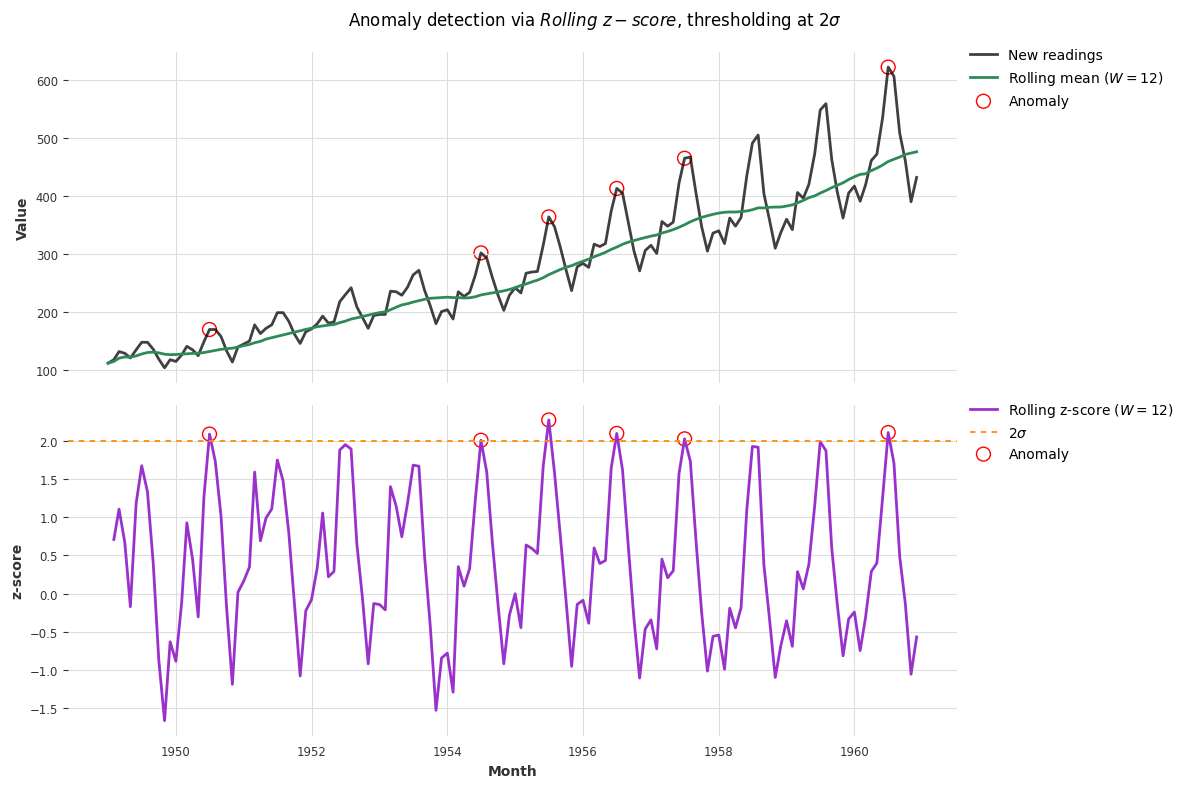

In [6]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
plt.suptitle(f"Anomaly detection via $Rolling \ z-score$, thresholding at {THRESHOLD}$\sigma$")

ax = ax0
series.plot(label="New readings", color="black", alpha=.75, ax=ax)
series_wndw_mean.plot(label=f"Rolling mean ($W={W}$)", color="seagreen", ax=ax)
ax.scatter(series.time_index[idx_anomalies], series.values()[idx_anomalies], color="none", edgecolor="red", s=100, label="Anomaly")

ax.set_xlabel(None)
ax.set_ylabel("Value")
ax.legend(bbox_to_anchor=(1, 1.05))

ax=ax1
series_wndw_zscore.plot(ax=ax, color="darkorchid", label=f"Rolling z-score ($W={W}$)")
ax.axhline(THRESHOLD, linestyle=(0, (3, 3)), color="darkorange", label=f"{THRESHOLD}$\sigma$")
ax.scatter(series_wndw_zscore.time_index[idx_anomalies], series_wndw_zscore.values()[idx_anomalies], color="none", edgecolor="red", s=100, label="Anomaly")

ax.set_ylabel("z-score")
ax.legend(bbox_to_anchor=(1, 1.05))

plt.tight_layout()
plt.show()